In [148]:
# module Import

# %matplotlib inline
import matplotlib.pyplot as plt # pip install matplotlib
from ChemInfoTools.CIMtools.preprocessing import Fragmentor # pip install pillow==9.4.0
from ChemInfoTools.CIMtools.preprocessing import solvent
from os import environ

## environ['PATH']+=":/home/pavel/envs/cgr/bin"
## needs to be reassigned if ISIDA descriptor generation is needed

from CGRtools import RDFRead, MoleculeContainer, ReactionContainer, SDFRead, SMILESRead, smiles, CGRContainer  # pip install CGRtools
import pandas as pd  # pip install pandas
from pandas import DataFrame 
import numpy as np
import pickle 

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.optimize import curve_fit

from ChemInfoTools.cheminfotools.chem_features import Augmentor, ComplexFragmentor, PassThrough, Pruner

import itertools
import xgboost # pip install xgboost
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor # pip install catboost

%config IPCompleter.use_jedi = False
cm = 1./2.54

# Methods

## Basic Methods

### Value Conveter

In [149]:
# Fraction - DDG

def fraction2ddg(fr, T):
    return 0.008314461536*T*np.log(fr/(100-fr))

def ddg2fraction(ddg, T):
    return 100*np.exp(ddg/(0.008314461536*T))/(1+np.exp(ddg/(0.008314461536*T)))

In [150]:
# ee - DDG
def ee2ddg(ee, T):
    fr = 50+(ee/2)
    return 0.008314461536*T*np.log(fr/(100-fr))

def ddg2ee(ddg, T):
    exp_part = np.exp(ddg / (0.008314461536 * T))
    ee = 2 * ((100 * exp_part / (1 + exp_part)) - 50)
    return ee

### Concentration calibration (현재 버전 필요x)

In [151]:
# Conc. calibration
def calib_function(x, a, b, T=333.15):
    return 8.31*T*np.log((a+x)/(b+x))
def calibrate(x, initial_conc, final_conc, coef, T, f=calib_function):
    y = f(final_conc, *coef, T=T)*np.abs(x)/f(initial_conc, *coef, T=T)*((x>0).astype(int)*2-1)
    return np.array(y)

## Model Methods

### Evaluation

In [152]:
# Evaluation (Regression)
def r2(a, b):
    return 1. - np.sum((a-b)**2)/np.sum((a-np.mean(a))**2)

def rmse(a, b):
    return np.sqrt(np.sum((a-b)**2)/len(a))

In [153]:
# Evaluation (Reg-Classification)
def div_accuracy(conf_mat):
    if len(conf_mat) ==4:
        sum = 0
        right = 0
        for i in conf_mat:
            sum+=i
            if i in [0,3]:
                right+=i
    elif len(conf_mat) ==9:
        sum = 0
        right = 0
        for i in conf_mat:
            sum+=i
            if i in [0,4,8]:
                right+=i
    return round(100*right/sum,2)

def div_recall(conf_mat):
    if len(conf_mat) ==4:
        return round(100*(conf_mat[3])/(conf_mat[2]+conf_mat[3]),2)
    
def div_precision(conf_mat):
    if len(conf_mat) ==4:
        return round(100*(conf_mat[3])/(conf_mat[1]+conf_mat[3]),2)

def div_f1_score(conf_mat):
    if len(conf_mat) == 4:
        TN, FP, FN, TP = conf_mat
        if (2 * TP + FP + FN) == 0:
            return 0
        f1 = 2 * TP / (2 * TP + FP + FN)
        return round(f1, 2)

### libsvm parser (현재 버전 필요x)

In [154]:
# libsvm parser
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectorMixin
    
def libsvm_parser(params_line):
    params = params_line.split(" ")
    c = float(params[params.index("-c")+1])
    coef0 = float(params[params.index("-r")+1])
    epsilon = float(params[params.index("-p")+1])
    kernel = int(params[params.index("-t")+1])
    if kernel == 0:
        kernel = "linear"
    elif kernel == 1:
        kernel = "poly"
    elif kernel == 2:
        kernel = "rbf"
    elif kernel == 3:
        kernel = "sigmoid" 
    
    return SVR(kernel=kernel, gamma="auto", coef0=coef0, C=c, epsilon=epsilon)

### Visualize

In [155]:
# VS plot
def vs_visualize(predicted_train, predicted_test, target_train, target_test, saveName=None):
    
    fig, box = plt.subplots(figsize=(4, 4), dpi=200, facecolor="w")

    # 테스트 데이터 포인트에 대한 주석 추가 
    for i, txt in enumerate(np.arange(len(target_test))):
        break
        box.annotate(txt + 1, (predicted_test[i], target_test[i]), fontsize=6, ha='right')
    
    # 예측 지표 text 만들기

    # 예측 지표 계산
    rmse_test = np.sqrt(mean_squared_error(target_test, predicted_test))
    mae_test = mean_absolute_error(target_test, predicted_test)
    r2_test = r2_score(target_test, predicted_test)
    r2_train = r2_score(target_train, predicted_train)
    textstr = '\n'.join((
            'RMSE=%.3f' % rmse_test,
            'MAE=%.3f' % mae_test,
            'R2=%.3f' % r2_test
        ))
    
    # 데이터 포인트 표시 및 제목, 대각선 그리기
    global target
    box.plot(predicted_train, target_train, "ko", markersize=3)
    box.plot(predicted_test, target_test, marker='o', linestyle='', color='crimson', markersize=3)
    plt_min = min(min(target_train), min(target_test))
    plt_max = max(max(target_train), max(target_test))
    box.plot([plt_min, plt_max], [plt_min, plt_max], color='crimson')  # 대각선 선 추가
    box.text(plt_min, plt_max, textstr, fontsize=7, 
        horizontalalignment='left', verticalalignment='top') # 예측 지표 텍스트 추가
    box.set_xlabel('Predicted ' + target)
    box.set_ylabel('Actual ' + target)
    plt.title(f'Pred vs. Actual {target}')
    plt.tight_layout()
    if saveName:
        plt.savefig(f"VSplot_{target}_{saveName}")
        plt.close(fig)
    plt.show()
    return rmse_test, mae_test, r2_test, r2_train
    



In [156]:
# VS plot

def vs_visualize_logscale(predicted_train, predicted_test, target_train, target_test, saveName=None):
    vectorized_ee2ddg = np.vectorize(ee2ddg)
    predicted_test = vectorized_ee2ddg(predicted_test, 300)
    target_test = vectorized_ee2ddg(target_test, 300)
    predicted_train = vectorized_ee2ddg(predicted_train, 300)
    target_train = vectorized_ee2ddg(target_train, 300)
    fig, box = plt.subplots(figsize=(4, 4), dpi=200, facecolor="w")

    # 테스트 데이터 포인트에 대한 주석 추가 
    for i, txt in enumerate(np.arange(len(target_test))):
        break
        box.annotate(txt + 1, (predicted_test[i], target_test[i]), fontsize=6, ha='right')
    
    # 예측 지표 text 만들기
    
    # 예측 지표 계산
    rmse_test = np.sqrt(mean_squared_error(target_test, predicted_test))
    mae_test = mean_absolute_error(target_test, predicted_test)
    r2_test = r2_score(target_test, predicted_test)
    r2_train = r2_score(target_train, predicted_train)
    textstr = '\n'.join((
            'RMSE=%.3f' % rmse_test,
            'MAE=%.3f' % mae_test,
            'R2=%.3f' % r2_test
        ))
    
    # 데이터 포인트 표시 및 제목, 대각선 그리기
    global target
    box.plot(predicted_train, target_train, "ko", markersize=3)
    box.plot(predicted_test, target_test, marker='o', linestyle='', color='crimson', markersize=3)
    plt_min = min(min(target_train), min(target_test))
    plt_max = max(max(target_train), max(target_test))
    box.plot([plt_min, plt_max], [plt_min, plt_max], color='crimson')  # 대각선 선 추가
    box.text(plt_min, plt_max, textstr, fontsize=7, 
        horizontalalignment='left', verticalalignment='top') # 예측 지표 텍스트 추가
    box.set_xlabel('Predicted ' + target)
    box.set_ylabel('Actual ' + target)
    plt.title(f'Pred vs. Actual {target}')
    plt.tight_layout()
    if saveName:
        plt.savefig(f"VSplot_{target}_{saveName}")
        plt.close(fig)
    plt.show()
    return rmse_test, mae_test, r2_test, r2_train
    



In [157]:
def vs_visualize_4grid(predicted_train, predicted_test, target_train, target_test, boundary,saveName=None):
    fig, box = plt.subplots(figsize=(4, 4), dpi=200, facecolor="w")

    boundary = 0
    # 테스트 데이터 포인트에 대한 주석 추가 및 영역 나누기
    region=[0,0,0,0]
    print(region,len(target_test) )    
    for i, txt in enumerate(np.arange(len(target_test))):
        box.annotate(txt + 1, (predicted_test[i], target_test[i]), fontsize=6, ha='right')
        if predicted_test[i]<boundary:
            if target_test[i]<boundary:
                region[0]+=1
            else:   
                region[2]+=1
        else :
            if target_test[i]<boundary:
                region[1]+=1
            else:   
                region[3]+=1
    
    # 예측 지표 text 만들기
    rmse_test = np.sqrt(rmse(target_test, predicted_test))
    mae_test = mae(target_test, predicted_test)
    r2_test = r2(target_test, predicted_test)
    
    r2_train = r2(target_train, predicted_train)
    acc = div_accuracy(region)
    recall = div_recall(region)
    f1 = div_f1_score(region)
    
    textstr = '\n'.join((
            'R2(train)=%.3f' % r2_train,
            'Acc.=%f'% acc,
            'Recall=%f'% recall,
            'F1-score=%f'% f1
            
        ))
    
    # 데이터 포인트 표시 및 제목, 대각선 그리기
    global target
    box.plot(predicted_train, target_train, "ko", markersize=3)
    box.plot(predicted_test, target_test, marker='o', linestyle='', color='crimson', markersize=3)
    plt_min = min(min(target_train), min(target_test))
    plt_max = max(max(target_train), max(target_test))
    box.plot([plt_min, plt_max], [plt_min, plt_max], color='crimson')  # 대각선 선 추가
    box.text(plt_min, plt_max, textstr, fontsize=7, 
        horizontalalignment='left', verticalalignment='top') # 예측 지표 텍스트 추가
    box.set_xlabel('Predicted ' + target)
    box.set_ylabel('Actual ' + target)
    plt.title(f'Pred vs. Actual {target}')
    plt.tight_layout()
    plt.show()
    if saveName:
        plt.savefig(f"VSplot_{target}_{saveName}")
        plt.close(fig)
    


### Custom loss (현재 버전 필요x)

In [158]:
def custom_loss(y_true, y_pred, penalty_factor=2):
    """
    예측값이 실제값보다 작을 경우 더 큰 손실을 부여하는 사용자 정의 손실 함수.
    :param y_true: 실제값 배열
    :param y_pred: 예측값 배열
    :param penalty_factor: 실제값보다 예측값이 작을 때 적용할 패널티 계수
    :return: 계산된 손실값
    """
    # 기본 MSE 계산
    base_loss = np.mean((y_true - y_pred) ** 2)
    
    # 예측값이 실제값보다 작은 경우의 추가 패널티
    penalty = np.mean((y_pred < y_true) * (y_true - y_pred) ** 2 * penalty_factor)
    
    # 총 손실
    total_loss = base_loss + penalty
    
    return total_loss

## Atom Indexing

In [159]:
# indexing atom : 각각의 원자에 번호 부여
def assign_atom_index(smiles, initial=101, atomcounting = False):
    separator = "QWERTYUIOPASDFGHJKLZXCVBNMc.[()-=@#$:1234567890"
    nonAtomic = ".[()-=@#$:1234567890"
    braket = False
    atomcount = 0
    element = ""
    result = ""
    for i in smiles:
        if i in separator:
            if i == "[":
                braket = True
                if element:
                    if element[-1] in nonAtomic:
                        result+=element
                        atomcount-=1
                    elif element[-1] == "]":
                        result+= element[:-1]+":"+str(initial+atomcount) + "]"
                    else:
                        result+="["+element+":"+str(initial+atomcount)+"]"
                    element=""
                    atomcount+=1
            if braket:
                element +=i
                
                continue
            if element:   
                if element[-1] in nonAtomic:
                        result+=element
                        atomcount-=1
                elif element[-1] == "]":
                        result+= element[:-1]+":"+str(initial+atomcount) + "]"
                else:
                        result+="["+element+":"+str(initial+atomcount)+"]"
                atomcount+=1
            element = i
        else:
            if i == "]":
                braket = False
            element +=i
    if element[-1] in nonAtomic:
        result+=element
        atomcount-=1
    elif element[-1] == "]":
        result+= element[:-1]+":"+str(initial+atomcount) + "]"
    else:
        result+="["+element+":"+str(initial+atomcount)+"]"
    atomcount+=1
    
    
    if atomcounting:
        return result, atomcount
    return result

### Abbreviation

In [160]:
# Ligand Abbreviation : 약어로 표기된 작용기를 SMILES로 변환
def get_abbre_dict(fileName, sheetName = "Ligands"):
    data_ligands = pd.read_excel(fileName, sheet_name=sheetName)
    data_ligands.fillna('')
    abbre_dict = dict(zip(data_ligands['Abbr'], data_ligands['Smiles']))    
    return abbre_dict

In [161]:
# Add ligands to catalyst : 촉매에 각 약어에 해당하는 작용기 결합
def get_full_catalyst(catalyst_smiles, R3, Ar):
    global abbre_dict
    full_catalyst = catalyst_smiles.replace("[R3]",abbre_dict[R3])
    full_catalyst = full_catalyst.replace("[Ar]",abbre_dict[Ar])
    return full_catalyst    

In [162]:
# Add ligands to reactant / product : 반응물/생성물에 각 약어에 해당하는 작용기 결합
def get_full_smiles(smiles, R1, R2):
    global abbre_dict
    R1 = abbre_dict[R1]
    R2 = abbre_dict[R2]
    _ , count = assign_atom_index(smiles, atomcounting=True)
    indexed_R1, R_count = assign_atom_index(R1, count,atomcounting=True)
    indexed_R2, R_count = assign_atom_index(R2, count+R_count+1, atomcounting=True)
    full_smiles = smiles.replace("[R1]", indexed_R1)
    full_smiles = full_smiles.replace("[R2]", indexed_R2)
    return full_smiles

### Reaction SMILES

In [163]:
# Reaction Information : 반응물, 생성물 및 촉매의 뼈대 불러오기
def get_reaction_info(reaction_name):
    global data_reaction
    row = data_reaction[data_reaction['Name']==reaction_name]
    if row.empty:
        return None, None, None

    reactant = row['Reactant'].values[0]
    Product = row['Product'].values[0]
    Catalyst = row['Catalyst'].values[0]
    
    return reactant, Product, Catalyst

In [164]:
# # merge to reaction smiles : 반응물 & 생성물 SMILES를 반응 SMILES로 병합
# def get_reaction_smiles(reactant_1, reactant_2, product, R):
#     reac = reactant_1+R+"."+reactant_2
#     prod = product+R
#     return reac+">>"+prod

### For simulation

In [165]:
# generate_combinations
def generate_combinations(fileName, sheetName = "Screen_simulate"):
    df = pd.read_excel(fileName, sheet_name=sheetName)
    # 각 열의 가능한 값들로 리스트 생성
    column_values = [df[col].dropna().unique().tolist() for col in df.columns]
    
    # 가능한 모든 조합 생성
    all_combinations = list(itertools.product(*column_values))
    
    # 조합을 데이터프레임으로 변환
    combinations_df = pd.DataFrame(all_combinations, columns=df.columns)
    
    return combinations_df

# Data preparation

### Load Data

In [166]:
# Get Data from Excel  : 엑셀에서 데이터 불러오기
FileName = "./data_files/SRC_2502-2substrate_250416.xlsx"#"SRC_202404dataset.xls"
abbre_dict= get_abbre_dict(FileName)
data_reaction = pd.read_excel(FileName, sheet_name="Reactions")
data_experiment = pd.read_excel(FileName, sheet_name="Exp") 

data_simulate = pd.read_excel(FileName, sheet_name="Exp_Simulate") # 일부 반응만 볼 때
data_simulate= generate_combinations(FileName) # 옵션을 가지고 combination 만들어서 많이

### Drop NAs

In [167]:
# dropna with target : 예측하고자하는 결과값이 없는 행들을 제거
target = 'ee' # ee, yield, ddG, regio 타겟 설정

print(len(data_experiment)) 
if target== 'ddG':
    data_experiment.dropna(subset=['ee'], inplace=True)
else:
    data_experiment.dropna(subset=[target], inplace=True)
print(len(data_experiment))


260
200


In [168]:
# make ddG array : ddG 없이 e.e.만 있는 경우 ddG로 변환
if target == 'ddG':
    target_experiment = np.array(ee2ddg(data_experiment['ee'], data_experiment["T(K)"]))
else:
    target_experiment = np.array(data_experiment[target])

### Add CGR columns

In [169]:
# Add features to DataFrame : full_catalyst, R3, Ar, CGR feature 추가
full_catalyst_column = []
R3_structure_column = []
Ar_structure_column = []
CGR_column =[]
smiles_cache = {}
for index, row in data_experiment.iterrows():
    #Get reaction information from the name : 실험 데이터에서 반응 이름 불러오기
    reac, prod , cata = get_reaction_info(row['Name'])
    
    #Make Catalysts feature : 전체 촉매와 촉매 작용기들을 각각 feature로 적용
    full_catalyst_column.append(smiles(get_full_catalyst(cata, row['R3'],row['Ar'])))
    
    reac_R3 = smiles(assign_atom_index("C"+abbre_dict[row['R3']],initial=1))
    prod_R3 = smiles(assign_atom_index("C"+abbre_dict[row['R3']],initial=1))
    prod_R3.delete_bond(1,2)
    R3_structure_column.append(reac_R3.compose(prod_R3))
    R3_structure_column[-1].clean2d()
    
    reac_Ar = smiles(assign_atom_index("C"+abbre_dict[row['Ar']],initial=1))
    prod_Ar = smiles(assign_atom_index("C"+abbre_dict[row['Ar']],initial=1))
    prod_Ar.delete_bond(1,2)
    Ar_structure_column.append(reac_Ar.compose(prod_Ar))
    Ar_structure_column[-1].clean2d()
    
    #Smiles Cacheing : 반응 이름과 작용기로부터 반응 SMILES 획득 및 CGR로 변환하여 Feature로 추가
    cache_key = (row['Name'], row['R1'], row['R2'])
    if cache_key not in smiles_cache:
        smiles_cache[cache_key] = {
            'indexed_prod':get_full_smiles(prod,row['R1'],row['R2']),
            'indexed_reac':get_full_smiles(reac,row['R1'],row['R2'])
        }
    reaction_smiles=smiles(smiles_cache[cache_key]['indexed_reac']+">>"+smiles_cache[cache_key]['indexed_prod'])
    CGR_column.append(reaction_smiles.compose())
data_experiment['mol_full'] = full_catalyst_column
data_experiment['mol_R3'] = R3_structure_column
data_experiment['mol_Ar'] = Ar_structure_column
data_experiment['CGR'] = CGR_column
a=data_experiment['CGR'][0]
a.clean2d()
data_experiment.head(5)

,Name,R1,R2,R3,Ar,solvent,T(K),yield,ee,regio,mol_full,mol_R3,mol_Ar,CGR
0,COBI,Ph,Me,Ph,Ph,toluene,300,90.0,95.90,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
1,COBI,4-MePh,Me,Ph,Ph,toluene,300,88.0,94.86,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2,COBI,4-FPh,Me,Ph,Ph,toluene,300,81.0,97.24,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
3,COBI,2-Naph,Me,Ph,Ph,toluene,300,52.0,96.17,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
4,COBI,Et,Me,Ph,Ph,toluene,300,43.0,80.48,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


In [170]:
# Add features to DataFrame : full_catalyst, Ar1, Ar2, CGR feature 추가
full_catalyst_column = []
R3_structure_column = []
Ar_structure_column = []
CGR_column =[]
smiles_cache = {}
for index, row in data_simulate.iterrows():
    #Get reaction information from the name : 실험 데이터에서 반응 이름 불러오기
    reac, prod , cata = get_reaction_info(row['Name'])
    
    #Make Catalysts feature : 전체 촉매와 촉매 작용기들을 각각 feature로 적용
    full_catalyst_column.append(smiles(get_full_catalyst(cata, row['R3'],row['Ar'])))
    
    reac_R3 = smiles(assign_atom_index("C"+abbre_dict[row['R3']],initial=1))
    prod_R3 = smiles(assign_atom_index("C"+abbre_dict[row['R3']],initial=1))
    prod_R3.delete_bond(1,2)
    R3_structure_column.append(reac_R3.compose(prod_R3))
    R3_structure_column[-1].clean2d()
    
    reac_Ar = smiles(assign_atom_index("C"+abbre_dict[row['Ar']],initial=1))
    prod_Ar = smiles(assign_atom_index("C"+abbre_dict[row['Ar']],initial=1))
    prod_Ar.delete_bond(1,2)
    Ar_structure_column.append(reac_Ar.compose(prod_Ar))
    Ar_structure_column[-1].clean2d()
    
    #Smiles Cacheing : 반응 이름과 작용기로부터 반응 SMILES 획득 및 CGR로 변환하여 Feature로 추가
    cache_key = (row['Name'], row['R1'], row['R2'])
    if cache_key not in smiles_cache:
        smiles_cache[cache_key] = {
            'indexed_prod':get_full_smiles(prod,row['R1'],row['R2']),
            'indexed_reac':get_full_smiles(reac,row['R1'],row['R2'])
        }
    reaction_smiles=smiles(smiles_cache[cache_key]['indexed_reac']+">>"+smiles_cache[cache_key]['indexed_prod'])
    CGR_column.append(reaction_smiles.compose())
data_simulate['mol_full'] = full_catalyst_column
data_simulate['mol_R3'] = R3_structure_column
data_simulate['mol_Ar'] = Ar_structure_column
data_simulate['CGR'] = CGR_column
a=data_simulate['CGR'][0]
a.clean2d()
data_simulate.head(5)

,Name,R1,R2,R3,Ar,solvent,T(K),mol_full,mol_R3,mol_Ar,CGR
0,COBI,4-MeOPh,Me,Ph,Ph,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
1,COBI,4-MeOPh,Me,Ph,4-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2,COBI,4-MeOPh,Me,Ph,2-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
3,COBI,4-MeOPh,Me,Ph,2-Naph,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
4,COBI,4-MeOPh,Me,Ph,4-FPh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


In [171]:
data_simulate

,Name,R1,R2,R3,Ar,solvent,T(K),mol_full,mol_R3,mol_Ar,CGR
0,COBI,4-MeOPh,Me,Ph,Ph,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
1,COBI,4-MeOPh,Me,Ph,4-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2,COBI,4-MeOPh,Me,Ph,2-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
3,COBI,4-MeOPh,Me,Ph,2-Naph,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
4,COBI,4-MeOPh,Me,Ph,4-FPh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
...,...,...,...,...,...,...,...,...,...,...,...
2587,COBI,Ph,Et,iPr,"2,6-Me2Ph",toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2588,COBI,Ph,Et,iPr,2-furan,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4)","(1, 2, 3, 4, 5, 6)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2589,COBI,Ph,Et,iPr,4-F-2-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2590,COBI,Ph,Et,iPr,4-Cl-2-MePh,toluene,300.0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


### Outliers Elimination

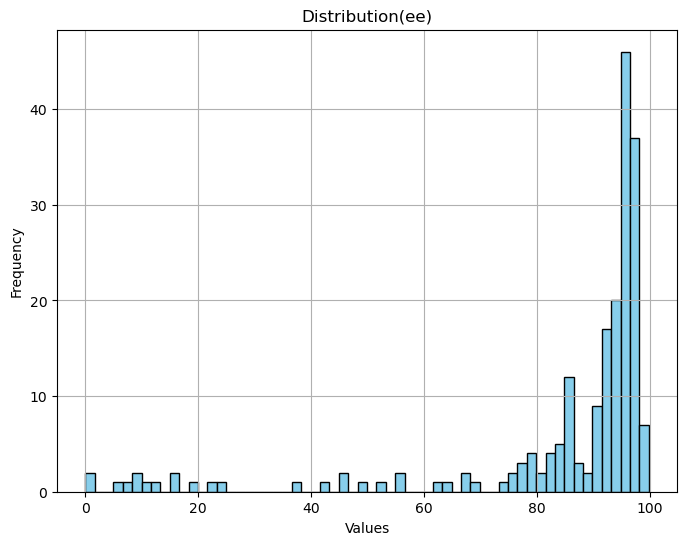

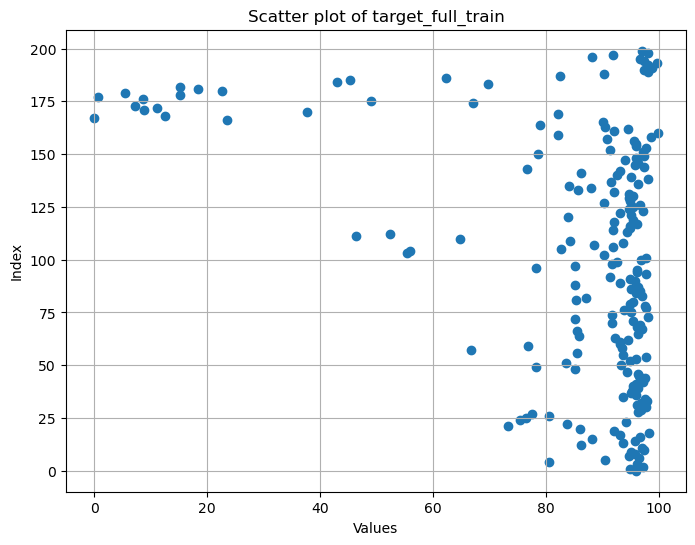

In [172]:
#Data plot
plt.figure(figsize=(8, 6))
plt.hist(target_experiment, bins=60, color='skyblue', edgecolor='black')
plt.title('Distribution('+target+')')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(target_experiment, np.arange(len(data_experiment)))
plt.title('Scatter plot of target_full_train')
plt.ylabel('Index')
plt.xlabel('Values')
plt.grid(True)
plt.show()

In [173]:
# Quartiles Method
Q1 = np.percentile(target_experiment, 25)
Q3 = np.percentile(target_experiment, 75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Q3:",Q3, ", Q1:",Q1, ", IQR:",IQR)
print("upper_bound:", upper_bound,"lower_bound:",lower_bound)

outlier_indices = np.where((target_experiment < lower_bound) | (target_experiment > upper_bound))[0]


Q3: 96.2225 , Q1: 85.2175 , IQR: 11.004999999999995
upper_bound: 112.72999999999999 lower_bound: 68.71000000000001


In [174]:
# z-score Method
z_scores = (target_experiment - np.mean(target_experiment)) / np.std(target_experiment)

threshold = 2 # Outlier threshold


outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
outlier_indices

array([166, 167, 168, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181,
       182], dtype=int64)

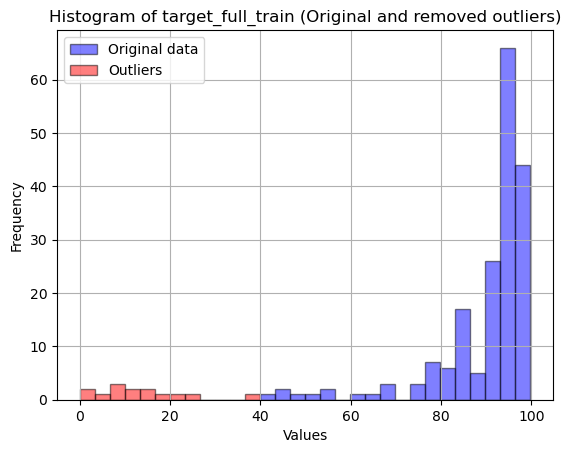

(186, 14) (186,)


In [175]:
# Plot Outliers and Originals
data_filtered = data_experiment[~np.isin(np.arange(len(data_experiment)), outlier_indices)]
target_filtered = target_experiment[~np.isin(np.arange(len(data_experiment)), outlier_indices)]

# 제거 안된 데이터를 히스토그램으로 표시 (파란색)
plt.hist(target_filtered, bins=30, range=(np.percentile(target_experiment, 0),np.percentile(target_experiment, 100)),color='blue', edgecolor='black', alpha=0.5, label='Original data')

# 제거된 이상치를 히스토그램으로 표시 (붉은색)
plt.hist(target_experiment[outlier_indices], bins=30,range=(np.percentile(target_experiment, 0),np.percentile(target_experiment, 100)), color='red', edgecolor='black', alpha=0.5, label='Outliers')
plt.title('Histogram of target_full_train (Original and removed outliers)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print(data_filtered.shape, target_filtered.shape)

# Models

In [176]:
random_seed = 42

## Model pipelines

In [177]:
SVR_pipeline = Pipeline([("fragmentor",ComplexFragmentor(associator={"mol_R3":Augmentor(lower=0, upper=4),
                                                "mol_Ar":Augmentor(lower=0, upper=4),
                                                "CGR":Augmentor(lower=0, upper=4),
                                                "mol_full":Augmentor(lower=0, upper=4),
                                                "solvent":solvent.SolventVectorizer()},
                                    structure_columns=["mol_R3", "mol_Ar", "CGR","mol_full"])),
        ("model",SVR(kernel="rbf", gamma=0.005, coef0=float(-8.4), C=float(4.458578e+02), epsilon=float(9.658290e-01)))
        ])

In [178]:
RF_pipeline = Pipeline([
    ("fragmentor", ComplexFragmentor(associator={
        "mol_R3": Augmentor(lower=0, upper=4),
        "mol_Ar": Augmentor(lower=0, upper=4),
        "CGR": Augmentor(lower=0, upper=4),
        "mol_full": Augmentor(lower=0, upper=4),
        "solvent": solvent.SolventVectorizer()
    }, structure_columns=["mol_R3", "mol_Ar", "CGR", "mol_full"])),
    ("model", RandomForestRegressor(random_state=random_seed, max_depth= 10, min_samples_split= 5, n_estimators= 100)) 
    # 10, 5, 100 for yield
]) 

In [179]:
XGB_pipeline = Pipeline([
    ("fragmentor", ComplexFragmentor(associator={
        "mol_R3": Augmentor(lower=0, upper=4),
        "mol_Ar": Augmentor(lower=0, upper=4),
        "CGR": Augmentor(lower=0, upper=4),
        "mol_full": Augmentor(lower=0, upper=4),
        "solvent": solvent.SolventVectorizer()
    }, structure_columns=["mol_R3", "mol_Ar", "CGR", "mol_full"])),
    ("model", XGBRegressor(enable_categorical=True, objective='reg:squarederror', n_estimators=100, random_state=random_seed))
])

# Before Training

### data split

In [180]:
data_train, data_test, target_train, target_test = train_test_split(data_filtered, target_filtered, test_size=0.1, random_state=random_seed)

In [181]:
data_train.head()

,Name,R1,R2,R3,Ar,solvent,T(K),yield,ee,regio,mol_full,mol_R3,mol_Ar,CGR
19,COBI,2-Naph,Me,Ph,2-MePh,toluene,300,30.0,92.12,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
80,COBI,Ph,Me,Ph,1-Naph,toluene,300,71.0,95.10,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
122,COBI,4-FPh,Me,"3,5-Me2Ph","3,5-Me2Ph",toluene,300,82.0,94.98,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
134,COBI,Ph,Et,"3,5-Me2Ph",4-FPh,toluene,300,82.0,96.61,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
155,COBI,2-Naph,Me,"3,5-Me2Ph","3,5-F2Ph",toluene,300,58.0,94.08,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


In [182]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# # 활성화 함수 (ReLU와 그 미분)
# def relu(x):
#     return np.maximum(0, x)

# def relu_derivative(x):
#     return np.where(x > 0, 1, 0)

# # 선형 활성화 함수 (회귀 문제용)
# def linear(x):
#     return x

# # 손실 함수 (MSE)와 그 미분
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)

# def mean_squared_error_derivative(y_true, y_pred):
#     return 2 * (y_pred - y_true) / y_true.size

# # ComplexFragmentor 클래스 정의
# class ComplexFragmentor:
#     def __init__(self, associator, structure_columns):
#         self.associator = associator
#         self.structure_columns = structure_columns

#     def fit_transform(self, X):
#         # 데이터의 특정 컬럼을 가공하여 결합하는 예시
#         transformed_data = []
#         for i, col in enumerate(self.structure_columns):
#             augmented = self.associator[col].augment(X[:, i])
#             transformed_data.append(augmented)
#         return np.hstack(transformed_data)

#     def transform(self, X):
#         return self.fit_transform(X)

# # Augmentor 클래스 정의
# class Augmentor:
#     def __init__(self, lower, upper):
#         self.lower = lower
#         self.upper = upper

#     def augment(self, data):
#         # 주어진 데이터에 lower와 upper 범위의 노이즈를 추가
#         noise = np.random.uniform(self.lower, self.upper, size=data.shape)
#         return data + noise

# # 신경망 클래스 정의 (MLP)
# class SimpleNeuralNetwork:
#     def __init__(self, input_size, hidden_size, output_size, lr=0.01):
#         # 가중치 초기화
#         self.W1 = np.random.randn(input_size, hidden_size)  # (input_size, hidden_size)
#         self.b1 = np.zeros((1, hidden_size))
#         self.W2 = np.random.randn(hidden_size, output_size)  # (hidden_size, output_size)
#         self.b2 = np.zeros((1, output_size))
#         self.lr = lr  # 학습률

#     # 순전파 (forward propagation)
#     def forward(self, X):
#         self.Z1 = np.dot(X, self.W1) + self.b1
#         self.A1 = relu(self.Z1)
#         self.Z2 = np.dot(self.A1, self.W2) + self.b2
#         return linear(self.Z2)  # 회귀 문제이므로 선형 활성화

#     # 역전파 (backpropagation)
#     def backward(self, X, y_true, y_pred):
#         # 출력층의 손실 미분
#         dZ2 = mean_squared_error_derivative(y_true, y_pred)
#         dW2 = np.dot(self.A1.T, dZ2)
#         db2 = np.sum(dZ2, axis=0, keepdims=True)

#         # 은닉층의 손실 미분
#         dA1 = np.dot(dZ2, self.W2.T)
#         dZ1 = dA1 * relu_derivative(self.Z1)
#         dW1 = np.dot(X.T, dZ1)
#         db1 = np.sum(dZ1, axis=0, keepdims=True)

#         # 가중치 업데이트
#         self.W1 -= self.lr * dW1
#         self.b1 -= self.lr * db1
#         self.W2 -= self.lr * dW2
#         self.b2 -= self.lr * db2

#     # 학습 함수
#     def fit(self, X, y, epochs=100):
#         for epoch in range(epochs):
#             y_pred = self.forward(X)
#             loss = mean_squared_error(y, y_pred)
#             self.backward(X, y, y_pred)
#             if epoch % 10 == 0:
#                 print(f"Epoch {epoch}, Loss: {loss}")

#     # 예측 함수
#     def predict(self, X):
#         return self.forward(X)

#     def score(self, X, y):
#         y_pred = self.predict(X)
#         loss = mean_squared_error(y, y_pred)
#         return -loss  # scikit-learn 스타일로 음수 반환

# # 파이프라인 대체: 전처리 + 신경망
# class DL_Pipeline:
#     def __init__(self, input_size, hidden_size, output_size, lr=0.01, epochs=100):
#         self.preprocessor = ComplexFragmentor(associator={
#             "mol_Ar1": Augmentor(lower=0, upper=4),
#             "mol_Ar2": Augmentor(lower=0, upper=4),
#             "CGR": Augmentor(lower=0, upper=4),
#             "mol_full": Augmentor(lower=0, upper=4),
#             "solvent": Augmentor(lower=0, upper=4)
#         }, structure_columns=["mol_Ar1", "mol_Ar2", "CGR", "mol_full"])
#         self.model = SimpleNeuralNetwork(input_size, hidden_size, output_size, lr)
#         self.epochs = epochs

#     def fit(self, X, y):
#         X_processed = self.preprocessor.fit_transform(X)
#         self.model.fit(X_processed, y, epochs=self.epochs)

#     def predict(self, X):
#         X_processed = self.preprocessor.transform(X)
#         return self.model.predict(X_processed)

#     def score(self, X, y):
#         y_pred = self.predict(X)
#         loss = mean_squared_error(y, y_pred)
#         return -loss  # 높은 점수가 좋은 성능이므로 음수로 반환

# # 데이터 예시 및 실행

# # 임의의 데이터 (예시)
# # data_filtered = np.random.randn(100, 4)  # 4개의 구조적 특성을 가진 데이터
# # target_filtered = np.random.randn(100, 1)  # 타겟 값

# # train_test_split으로 데이터를 분리
# data_train, data_test, target_train, target_test = train_test_split(data_filtered, target_filtered, test_size=0.2, random_state=42)

# # 모델 학습 및 평가
# input_size = data_train.shape[1]  # 특성 수
# output_size = 1  # 출력 수 (회귀 문제)
# hidden_size = 64  # 은닉층 크기

# dl_pipeline = DL_Pipeline(input_size=input_size, hidden_size=hidden_size, output_size=output_size, lr=0.01, epochs=100)
# dl_pipeline.fit(data_train, target_train)

# # 성능 평가
# train_score = dl_pipeline.score(data_train, target_train)
# test_score = dl_pipeline.score(data_test, target_test)

# print(f"Train Score (MSE): {-train_score}")
# print(f"Test Score (MSE): {-test_score}")

# # 예측
# predictions = dl_pipeline.predict(data_test)
# print("Predictions:", predictions)


## Hyperparameter tuning

### Gridsearch for RF

In [183]:
# from sklearn.model_selection import GridSearchCV
# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'model__n_estimators': [30, 50, 70],
#     'model__max_depth': [5, 10, None],
#     'model__min_samples_split': [2, 4, 6],
#     'model__max_features': ['auto', 'sqrt']
# }

# # GridSearchCV 설정
# grid_search = GridSearchCV(RF_pipeline, param_grid, cv=3, verbose=3, scoring='neg_mean_squared_error')

# # 데이터 로드
# # X_train, y_train, X_test, y_test = data_train, target_train, data_test, target_test

# # 그리드 서치 실행
# grid_search.fit(data_train, target_train)

# # 최적의 파라미터 출력
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

# # 테스트 데이터에 대한 성능 평가
# test_score = grid_search.score(data_test, target_test)
# print("Test set score: {:.2f}".format(-test_score))

# Get fancy figures(RF)

In [184]:
for random_seeds in range(5):
    break
    data_train, data_test, target_train, target_test = train_test_split(data_filtered, target_filtered, test_size=0.2, random_state=random_seeds)
    RF_pipelines = []
    for i in range(3):
        RF_pipelines.append(Pipeline([
            ("fragmentor", ComplexFragmentor(associator={
                "mol_R3": Augmentor(lower=0, upper=4),
                "mol_Ar": Augmentor(lower=0, upper=4),
                "CGR": Augmentor(lower=0, upper=4),
                "mol_full": Augmentor(lower=0, upper=4),
                "solvent": solvent.SolventVectorizer()
            }, structure_columns=["mol_R3", "mol_Ar", "CGR", "mol_full"])),
            ("model", RandomForestRegressor(random_state=i, max_depth= 10, min_samples_split= 5, n_estimators= 100)) 
            ]))
    i=0
    for RF_pl in RF_pipelines:
        RF_pl.fit(data_train, target_train)
        predicted_train = RF_pl.predict(data_train)
        predicted_test = RF_pl.predict(data_test)
        vs_visualize(predicted_train, predicted_test, target_train, target_test, saveName=f"RF_{target}_{random_seeds}_{i}")
        i+=1
        
    

In [185]:
RF_pipeline = Pipeline([
    ("fragmentor", ComplexFragmentor(associator={
        "mol_R3": Augmentor(lower=0, upper=4),
        "mol_Ar": Augmentor(lower=0, upper=4),
        "CGR": Augmentor(lower=0, upper=4),
        "mol_full": Augmentor(lower=0, upper=4),
        "solvent": solvent.SolventVectorizer()
    }, structure_columns=["mol_R3", "mol_Ar", "CGR", "mol_full"])),
    ("model", RandomForestRegressor(random_state=random_seed, max_depth= 10, min_samples_split= 3, n_estimators= 100)) 
])

In [186]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
# 성능 지표 저장을 위한 리스트
mse_scores = []
mae_scores = []
r2_scores = []

# KFold 교차 검증
for fold_index, (train_index, valid_index) in enumerate(kf.split(data_train)):
    data_cvtrain, data_valid = data_train.iloc[train_index], data_train.iloc[valid_index]
    target_cvtrain, target_valid = target_train[train_index], target_train[valid_index]

    RF_pipeline.fit(data_cvtrain, target_cvtrain)
    predicted_train = RF_pipeline.predict(data_cvtrain)
    predicted_valid = RF_pipeline.predict(data_valid)
    
    # 성능 지표 계산
    mse = mean_squared_error(target_valid, predicted_valid)
    mae = mean_absolute_error(target_valid, predicted_valid)
    r2 = r2_score(target_valid, predicted_valid)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    # 각 폴드별 시각화 저장
    vs_visualize_logscale(predicted_train, predicted_valid, target_cvtrain, target_valid, saveName=f"RFlog_{target}_{random_seed}_fold{fold_index}")
    vs_visualize(predicted_train, predicted_valid, target_cvtrain, target_valid, saveName=f"RF_{target}_{random_seed}_fold{fold_index}")

    # 각 폴드별 결과 출력
    print(f"Fold {fold_index + 1} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# 전체 결과 요약
print("\nCross-validation results:")
print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1 - MSE: 46.3323, MAE: 4.7305, R²: 0.6400
Fold 2 - MSE: 89.8623, MAE: 5.2716, R²: 0.5254
Fold 3 - MSE: 46.9820, MAE: 4.5986, R²: 0.5169
Fold 4 - MSE: 40.0446, MAE: 4.1555, R²: 0.5565
Fold 5 - MSE: 30.8945, MAE: 3.5123, R²: 0.6538

Cross-validation results:
Average MSE: 50.8231 ± 20.3583
Average MAE: 4.4537 ± 0.5902
Average R²: 0.5785 ± 0.0576


In [187]:
RF_pipeline.fit(data_train, target_train)

predicted_train = RF_pipeline.predict(data_train)
predicted_test = RF_pipeline.predict(data_test)
fold_index='total'
vs_visualize(predicted_train, predicted_test, target_train, target_test, saveName=f"RF_{target}_{random_seeds}_fold{fold_index}")
vs_visualize_logscale(predicted_train, predicted_test, target_train, target_test, saveName=f"RFlog_{target}_{random_seeds}_fold{fold_index}")


(1.66228021901295, 1.3453742061672553, 0.3809832985290277, 0.8216944891775593)

In [188]:
RF_pipeline.fit(data_filtered, target_filtered)
predicted = RF_pipeline.predict(data_filtered)
fold_index=33
vs_visualize(predicted, predicted, target_filtered, target_filtered, saveName=f"RF_{target}_{random_seeds}_fold{fold_index}")
vs_visualize_logscale(predicted, predicted, target_filtered, target_filtered, saveName=f"RFlog_{target}_{random_seeds}_fold{fold_index}")


(1.0175146960673291,
 0.7388343023161463,
 0.8158570828231033,
 0.8158570828231033)

In [189]:
data_filtered.iloc[60:69]

,Name,R1,R2,R3,Ar,solvent,T(K),yield,ee,regio,mol_full,mol_R3,mol_Ar,CGR
64,COBI,Ph,Me,Ph,"3,5-F2Ph",toluene,300,60.0,93.08,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
65,COBI,4-MePh,Me,Ph,"3,5-F2Ph",toluene,300,40.0,93.08,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
66,COBI,4-FPh,Me,Ph,"3,5-F2Ph",toluene,300,46.0,94.61,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
67,COBI,2-Naph,Me,Ph,"3,5-F2Ph",toluene,300,23.0,92.28,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
68,COBI,Et,Me,Ph,"3,5-F2Ph",toluene,300,46.0,85.94,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
70,COBI,Ph,Et,Ph,"3,5-F2Ph",toluene,300,69.0,96.38,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
71,COBI,MeO,Me,Ph,"3,5-F2Ph",toluene,300,99.0,85.42,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
72,COBI,Ph,Me,Ph,2-Naph,toluene,300,83.0,97.05,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
73,COBI,4-MePh,Me,Ph,2-Naph,toluene,300,83.0,96.10,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


In [190]:
target_filtered[90:99]

array([95.82, 94.82, 91.29, 97.79, 96.05, 96.12, 78.28, 85.12, 91.65])

# Simulation

In [191]:
data_train.head()

,Name,R1,R2,R3,Ar,solvent,T(K),yield,ee,regio,mol_full,mol_R3,mol_Ar,CGR
19,COBI,2-Naph,Me,Ph,2-MePh,toluene,300,30.0,92.12,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
80,COBI,Ph,Me,Ph,1-Naph,toluene,300,71.0,95.10,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
122,COBI,4-FPh,Me,"3,5-Me2Ph","3,5-Me2Ph",toluene,300,82.0,94.98,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
134,COBI,Ph,Et,"3,5-Me2Ph",4-FPh,toluene,300,82.0,96.61,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
155,COBI,2-Naph,Me,"3,5-Me2Ph","3,5-F2Ph",toluene,300,58.0,94.08,NaN,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9)","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."


In [192]:
model = RF_pipeline
model.fit(data_filtered, target_filtered)
predicted_simulate = model.predict(data_simulate)

In [193]:
name = 'RF'
data_simulate[target +' pred by '+name] = predicted_simulate
if target == 'ddG':
    ee_by_predicted_ddg = np.array(ddg2ee(data_simulate[target +' pred by '+name], data_simulate["T(K)"]))
    data_simulate['ee pred by ' +name]=ee_by_predicted_ddg
with pd.ExcelWriter(FileName, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    data_simulate.to_excel(writer, sheet_name='Simulation_Result', index=False)

# Figure making

In [194]:

RxnName, R1, R2 = 'COBI', '3,5-Me2Ph', 'Me'
cache_key = (RxnName, R1, R2)
reac, prod , cata = get_reaction_info(RxnName)
indexed_prod=get_full_smiles(prod,R1, R2)
indexed_reac=get_full_smiles(reac,R1, R2)
reaction_smiles=smiles(indexed_reac+">>"+indexed_prod)

# indexed_reac = '[Si:1]([C:2])([C:3])[c:4]1[c:5][c:6][c:7][c:8][c:9]1.[O:11]=[C:10]([C:17])[C:12](=[O:13])[C:15]'
# indexed_prod = '[C:10]([C:17])([O:11][Si:1]([C:2])([C:3])[c:4]1[c:5][c:6][c:7][c:8][c:9]1)[C:12](=[O:13])[C:15]'
# indexed_reac = '[Si:1](C)(C)c1ccccc1.O=C(C)C(=O)C'
# indexed_prod = 'C(C)(O[Si:1](C)(C)c1ccccc1)C(=O)C'
# reaction_smiles=smiles(indexed_reac+">>"+indexed_prod)
prod

'[C:10]([R2])([O:11][Si:1]([C:2])([C:3])[c:4]1[c:5][c:6][c:7][c:8][c:9]1)[C:12](=[O:13])[R1]'

In [195]:
reaction_smiles.clean2d()
reaction_smiles

In [196]:

cgr=reaction_smiles.compose()
cgr.clean2d()
cgr
